#Importy

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array

#Eksploracja danych

In [41]:
def load_file_to_df(folder_path):
  folder = [folder_path/'looks good',folder_path/'sit up straight',folder_path/'straighten head']
  df = pd.DataFrame()
  links = []
  classes = []
  size =[]
  for i,folder in enumerate(folder):
    print(folder)
    print(i)
    if not folder.is_dir():
        print(f"Warning: Directory not found: {folder}")
        continue
    for plik in folder.iterdir():
        if plik.is_file() and plik.suffix.lower() in ['.jpg', '.jpeg', '.png']:
          obraz = cv2.imread(str(plik))
          size.append(obraz.shape)
          links.append(str(plik))
          classes.append(i) # 0 looks good 1 sit up straight, 2 straighten head
  df['links'] = links
  df['classes'] = classes
  df['size'] = size
  return df


In [42]:
folder_path = Path('/content/drive/MyDrive/sensoryczne/posture_correction/train/')
train = load_file_to_df(folder_path)
folder_path = Path('/content/drive/MyDrive/sensoryczne/posture_correction/test/')
test = load_file_to_df(folder_path)
folder_path = Path('/content/drive/MyDrive/sensoryczne/posture_correction/valid/')
validation = load_file_to_df(folder_path)

/content/drive/MyDrive/sensoryczne/posture_correction/train/looks good
0
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight
1
/content/drive/MyDrive/sensoryczne/posture_correction/train/straighten head
2
/content/drive/MyDrive/sensoryczne/posture_correction/test/looks good
0
/content/drive/MyDrive/sensoryczne/posture_correction/test/sit up straight
1
/content/drive/MyDrive/sensoryczne/posture_correction/test/straighten head
2
/content/drive/MyDrive/sensoryczne/posture_correction/valid/looks good
0
/content/drive/MyDrive/sensoryczne/posture_correction/valid/sit up straight
1
/content/drive/MyDrive/sensoryczne/posture_correction/valid/straighten head
2


Found 3309 validated image filenames belonging to 3 classes.


In [ ]:
#koncowo nie użyta funkcja z powodów długiego proceoswania dnaych do df co mijało sie z celem
def resize_with_padding(image, target_size=(224, 224)): # musimy zresizować żeby zdjęcia mogły zostać przyjęte do transfer learningu a nie chcemy utracić danych wiecj resizeujemy z padingiem
    old_size = image.shape[:2]  # (height, width)
    ratio = min(target_size[0]/old_size[0], target_size[1]/old_size[1])
    new_size = (int(old_size[1]*ratio), int(old_size[0]*ratio))

    resized = cv2.resize(image, new_size)

    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h//2, delta_h - (delta_h//2)
    left, right = delta_w//2, delta_w - (delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_im

In [ ]:
df_train= train.sample(frac=1).reset_index(drop=True)
df_train.to_csv('/content/drive/MyDrive/sensoryczne/df_train.csv')
df_test= test.sample(frac=1).reset_index(drop=True)
df_test.to_csv('/content/drive/MyDrive/sensoryczne/df_test.csv')
df_validation= validation.sample(frac=1).reset_index(drop=True)
df_validation.to_csv('/content/drive/MyDrive/sensoryczne/df_validation.csv')

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_test.csv')
df_validation = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_validation.csv')

In [ ]:
def resize_and_crop_shorter_edge(img, target_size=224):
    h, w = img.shape[:2]

    # Oblicz nowy rozmiar zachowując proporcje
    if h < w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    img_resized = cv2.resize(img, (new_w, new_h))

    # Przytnij lub wycentruj do dokładnego wymiaru
    start_x = (new_w - target_size) // 2 if new_w > target_size else 0
    start_y = (new_h - target_size) // 2 if new_h > target_size else 0
    cropped = img_resized[start_y:start_y+target_size, start_x:start_x+target_size]
    return cropped
new_image_paths = []
for idx, path in enumerate(df_train['links']):
    img = cv2.imread(path)
    if img is None:
        print(f"Błąd wczytania: {path}")
        continue

    processed = resize_and_crop_shorter_edge(img)

    # Generujemy nową nazwę
    base, ext = os.path.splitext(path)
    new_path = f"{base}_aug{ext}"
    print(new_path)
    # Zapisujemy przekształcony obraz
    cv2.imwrite(new_path, processed)
    new_image_paths.append(new_path)

# Dodajemy nowe wiersze do DataFrame
df_aug = df_train.copy()
df_aug['links'] = new_image_paths
df_combined = pd.concat([df_train, df_aug], ignore_index=True)

print(f"Liczba oryginalnych zdjęć: {len(df_train)}")
print(f"Liczba po augmentacji: {len(df_combined)}")

/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight/extract0825_jpg.rf.c2f554e253ce0c92adcbce97bedf5de9_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight/mb0125_jpg.rf.df05fa7bc85fd1bf898238156fd2e27e_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/straighten head/extract0614_jpg.rf.d97298787212e85996393cd3fb5c9ba0_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight/mb0525_jpg.rf.e816eb9945f99d609d9e870e03688622_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/looks good/extract0005_jpg.rf.204958541e32667aeaa5e2beb0a39a7f_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight/extract0673_jpg.rf.6711e4aec021db908ff674ae50f678e1_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit up straight/extract3414_jpg.rf.8d30ebc41a88ccfeb7d9fb17391c1d68_aug.jpg
/content/drive/MyDrive/sensoryczne/posture_correction/train/sit

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
df_train['classes'] = df_train['classes'].astype(str)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,    # przesunięcie poziome
    height_shift_range=0.1,   # przesunięcie pionowe
    shear_range=0.1,          # ścinanie (perspektywa)
    brightness_range=[0.8, 1.2],  # jasność
    fill_mode='nearest'       # sposób uzupełniania po transformacjach
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


NameError: name 'df_train' is not defined

In [ ]:

print(df_train)
df_train.info()
df_train.describe()
df_train.dropna()
im1 = cv2_imread(df_train['links'][0])
im1 = resize_with_padding(im1)
cv2_imshow(im1)

      Unnamed: 0                                              links  classes  \
0              0  /content/drive/MyDrive/sensoryczne/posture_cor...        1   
1              1  /content/drive/MyDrive/sensoryczne/posture_cor...        2   
2              2  /content/drive/MyDrive/sensoryczne/posture_cor...        2   
3              3  /content/drive/MyDrive/sensoryczne/posture_cor...        0   
4              4  /content/drive/MyDrive/sensoryczne/posture_cor...        2   
...          ...                                                ...      ...   
6613        6613  /content/drive/MyDrive/sensoryczne/posture_cor...        2   
6614        6614  /content/drive/MyDrive/sensoryczne/posture_cor...        0   
6615        6615  /content/drive/MyDrive/sensoryczne/posture_cor...        0   
6616        6616  /content/drive/MyDrive/sensoryczne/posture_cor...        1   
6617        6617  /content/drive/MyDrive/sensoryczne/posture_cor...        1   

                 size  
0       (224, 2

NameError: name 'resize_with_padding' is not defined

#Podejście z MEDIAPIPEM


In [ ]:
!pip install mediapipe --quiet

import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import mediapipe as mp
from tqdm import tqdm

def extract_and_save_per_image(df: pd.DataFrame,
                               output_dir: str,
                               suffix: str = ".npz",
                               static_image_mode: bool = True,
                               model_complexity: int = 1,
                               min_detection_confidence: float = 0.5):
    """
    For each row in df (with columns ['links','classes']), runs MediaPipe Pose
    and saves a .npz per image containing:
      - landmarks: shape (132,) float32
      - label:     integer class

    Files are named <original_image_stem>.npz and placed under output_dir,
    preserving no subfolders (but you can easily re-add those if you like).
    """
    mp_pose = mp.solutions.pose
    pose    = mp_pose.Pose(
                static_image_mode=static_image_mode,
                model_complexity=model_complexity,
                min_detection_confidence=min_detection_confidence
              )

    out_path = Path(output_dir)
    try:
        out_path.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"Error creating directory {out_path}: {e}")
        # Depending on the severity, you might want to exit here
        return


    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Saving to {output_dir}"):
        img_path = Path(row['links'])
        img      = cv2.imread(str(img_path))

        # Run Pose
        lm_flat = [0.]*132
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            res     = pose.process(img_rgb)
            if res.pose_landmarks:
                lm_flat = []
                for lm in res.pose_landmarks.landmark:
                    lm_flat += [lm.x, lm.y, lm.z, lm.visibility]

        lm_arr = np.array(lm_flat, dtype=np.float32)
        label  = int(row['classes'])

        # Save .npz: contains 'landmarks' and 'label'
        save_fname = img_path.stem + suffix
        np.savez(out_path / save_fname,
                 landmarks=lm_arr,
                 label=label)

# --- USAGE ---

# 1. Load your CSVs
df_train      = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_train.csv')
df_test       = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_test.csv')
df_validation = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_validation.csv')

# 2. Point to an output folder of your choice
train_out = '/content/drive/MyDrive/sensoryczne/landmarks/train/'
test_out  = '/content/drive/MyDrive/sensoryczne/landmarks/test/'
val_out   = '/content/drive/MyDrive/sensoryczne/landmarks/valid/'
#
# 3. Run it!
extract_and_save_per_image(df_train,      train_out)
extract_and_save_per_image(df_test,       test_out)
extract_and_save_per_image(df_validation, val_out)


Saving to /content/drive/MyDrive/sensoryczne/landmarks/train/: 100%|██████████| 6618/6618 [13:50<00:00,  7.97it/s]
Saving to /content/drive/MyDrive/sensoryczne/landmarks/test/: 100%|██████████| 675/675 [01:13<00:00,  9.17it/s]
Saving to /content/drive/MyDrive/sensoryczne/landmarks/valid/: 100%|██████████| 682/682 [01:22<00:00,  8.31it/s]


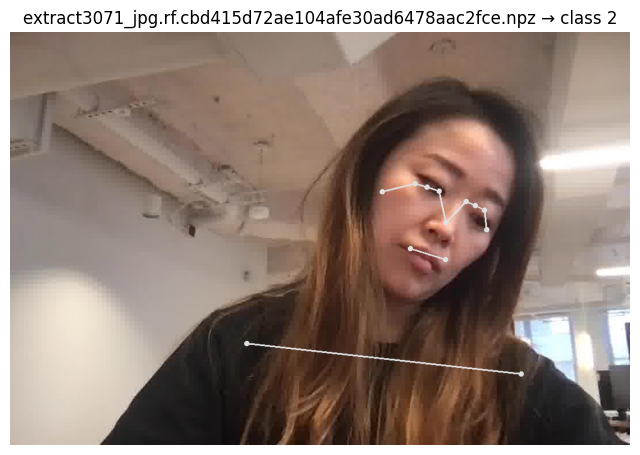

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats.landmark_pb2 import (
    NormalizedLandmarkList,
    NormalizedLandmark
)
from pathlib import Path
import pandas as pd

# 1) Load your train CSV so you can look up the original image paths:
df_train = pd.read_csv('/content/drive/MyDrive/sensoryczne/df_train.csv')

# 2) Pick one .npz at random (or by index):
npz_dir = Path('/content/drive/MyDrive/sensoryczne/landmarks/train/')
npz_files = list(npz_dir.glob('*.npz'))
npz_path = npz_files[1]
stem    = npz_path.stem

# 3) Look up the matching original image path in df_train:
row = df_train[df_train['links'].str.contains(stem)]
if row.empty:
    raise FileNotFoundError(f"No entry in df_train for image stem '{stem}'")
img_path = Path(row['links'].values[0])

# 4) Read the image and check:
img_bgr = cv2.imread(str(img_path))
if img_bgr is None:
    raise FileNotFoundError(f"Could not load image at {img_path}")

# 5) Load landmarks and reshape
data    = np.load(npz_path)
lm_flat = data['landmarks']                   # (132,)
lm      = lm_flat.reshape(-1, 4)              # (33,4): x,y,z,visibility

# 6) Convert to RGB and rebuild the LandmarkList
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

mp_lms = NormalizedLandmarkList(
    landmark=[
        NormalizedLandmark(x=float(x),
                           y=float(y),
                           z=float(z),
                           visibility=float(v))
        for x, y, z, v in lm
    ]
)

# 7) Draw on the image
annotated = img_rgb.copy()
mp.solutions.drawing_utils.draw_landmarks(
    annotated,
    mp_lms,
    mp.solutions.pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(), connection_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(thickness=2)
)

# 8) Display
plt.figure(figsize=(8, 8))
plt.imshow(annotated)
plt.axis('off')
plt.title(f"{npz_path.name} → class {int(data['label'])}")
plt.show()


##WCZYTYWANIE DANYCH ZPIPOWANYCH


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from pathlib import Path

class PoseLandmarkDataset(Dataset):
    def __init__(self, landmark_dir):
        self.files = list(Path(landmark_dir).rglob('*.npz'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        x = data['landmarks'].astype(np.float32)   # shape (132,)
        y = int(data['label'])                     # integer label (0–2)
        return torch.tensor(x), torch.tensor(y)


In [ ]:
train_ds = PoseLandmarkDataset('/content/drive/MyDrive/sensoryczne/landmarks/train')
val_ds   = PoseLandmarkDataset('/content/drive/MyDrive/sensoryczne/landmarks/valid')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


##Trenowanie modelu statystycznego

In [ ]:
import torch.nn as nn

class PoseClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(132, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # 3 classes
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):  # Try more epochs later
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Train loss: 0.9805
Epoch 2, Train loss: 0.8646
Epoch 3, Train loss: 0.8000
Epoch 4, Train loss: 0.7478
Epoch 5, Train loss: 0.7413
Epoch 6, Train loss: 0.7264
Epoch 7, Train loss: 0.7133
Epoch 8, Train loss: 0.6934
Epoch 9, Train loss: 0.6885
Epoch 10, Train loss: 0.6809


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Validation accuracy: {correct / total * 100:.2f}%")


Validation accuracy: 54.55%


In [ ]:
# Save model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/sensoryczne/pose_classifier.pth')
print("Model saved!")


Model saved!


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Collect all train data into X, y
X_train = []
y_train = []

for file in train_ds.files:
    data = np.load(file)
    X_train.append(data['landmarks'])
    y_train.append(data['label'])

X_train = np.stack(X_train)
y_train = np.array(y_train)

# Same for validation
X_val = []
y_val = []

for file in val_ds.files:
    data = np.load(file)
    X_val.append(data['landmarks'])
    y_val.append(data['label'])

X_val = np.stack(X_val)
y_val = np.array(y_val)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train logistic regression
# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_train_scaled, y_train)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_scaled, y_train)
preds = clf.predict(X_val_scaled)
acc = accuracy_score(y_val, preds)
print(f"Random Forest Accuracy: {acc * 100:.2f}%")





Random Forest Accuracy: 67.30%


In [ ]:
import joblib
joblib.dump(clf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

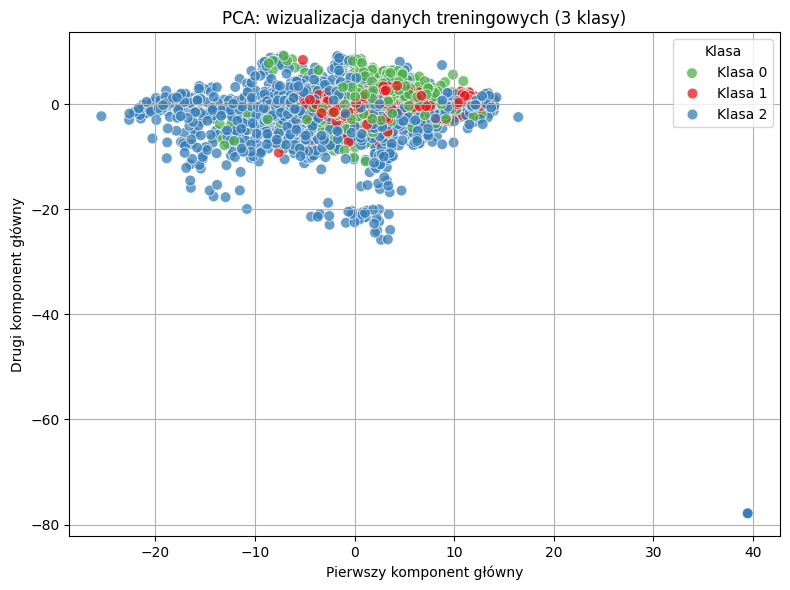

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=y_train,
    palette='Set1',  # np. czerwony, niebieski, zielony
    s=60, alpha=0.75
)

plt.title('PCA: wizualizacja danych treningowych (3 klasy)')
plt.xlabel('Pierwszy komponent główny')
plt.ylabel('Drugi komponent główny')
plt.legend(title='Klasa', labels=['Klasa 0', 'Klasa 1', 'Klasa 2'])
plt.grid(True)
plt.tight_layout()
plt.show()

##Fine tuning na pose


In [ ]:
model = LandmarkClassifier()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Trening
for epoch in range(10):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 0.9325
Epoch 2 Loss: 0.9926
Epoch 3 Loss: 0.9753
Epoch 4 Loss: 0.7490
Epoch 5 Loss: 0.8641
Epoch 6 Loss: 0.7849
Epoch 7 Loss: 0.8917
Epoch 8 Loss: 0.8684
Epoch 9 Loss: 0.7803
Epoch 10 Loss: 0.6299


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        predicted = outputs.argmax(1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 51.61%


#Transfer learning (1 Próba)

In [ ]:
X_train = []
y_train = []

for file in train_ds.files:
    data = np.load(file)
    X_train.append(data['landmarks'])
    y_train.append(data['label'])

X_train = np.stack(X_train)
y_train = np.array(y_train)

# Same for validation
X_val = []
y_val = []

for file in val_ds.files:
    data = np.load(file)
    X_val.append(data['landmarks'])
    y_val.append(data['label'])

X_val = np.stack(X_val)
y_val = np.array(y_val)


In [ ]:
X_train

array([[ 3.4787723e-01,  2.4088812e-01, -1.6884264e+00, ...,
         3.0143607e+00,  1.9685836e-01,  1.5287909e-04],
       [ 7.0312709e-01,  4.6379063e-01, -7.9926550e-01, ...,
         3.1837225e+00, -2.3398250e-01,  4.6156656e-05],
       [ 5.1637489e-01,  3.2862353e-01, -1.5852860e+00, ...,
         3.0470178e+00, -6.6746503e-02,  8.6582084e-05],
       ...,
       [ 5.8533037e-01,  3.0298916e-01, -1.3927536e+00, ...,
         2.9559731e+00, -6.8140757e-01,  1.3812653e-04],
       [ 5.8506340e-01,  2.7482271e-01, -2.1681252e+00, ...,
         4.2234378e+00, -5.2337927e-01,  1.1268600e-04],
       [ 5.0611711e-01,  4.5541573e-01, -2.0550156e+00, ...,
         3.5250368e+00, -2.0826836e-01,  3.9071849e-05]], dtype=float32)

In [ ]:
df_train['classes'] = df_train['classes'].astype(str)
train_datagen = ImageDataGenerator(     #wystąpiło przeuczenie robię wieksze data augmentation
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

KeyError: 'links'

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # softmax dla klasyfikacji wieloklasowej

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)
df_validation['classes'] = df_validation['classes'].astype(str)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_validation,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
df_test['classes'] = df_test['classes'].astype(str)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 682 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 2414s 23s/step - accuracy: 0.5650 - loss: 0.9352 - val_accuracy: 0.6364 - val_loss: 0.8208
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 593ms/step - accuracy: 0.7204 - loss: 0.6906 - val_accuracy: 0.6408 - val_loss: 0.7971
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 582ms/step - accuracy: 0.7808 - loss: 0.5881 - val_accuracy: 0.6716 - val_loss: 0.7761
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 586ms/step - accuracy: 0.7729 - loss: 0.5593 - val_accuracy: 0.6833 - val_loss: 0.7753
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 582ms/step - accuracy: 0.8028 - loss: 0.5062 - val_accuracy: 0.6657 - val_loss: 0.7996
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 581ms/step - accuracy: 0.8029 - loss: 0.4851 - val_accuracy: 0.6774 - val_loss: 0.7987
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 60s 574ms/step - accuracy: 0.8053 - loss: 0.4825 - val_accuracy: 0.7023 - val_loss: 0.7248
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 61s 586ms/step - accuracy: 0.8165 - loss: 0

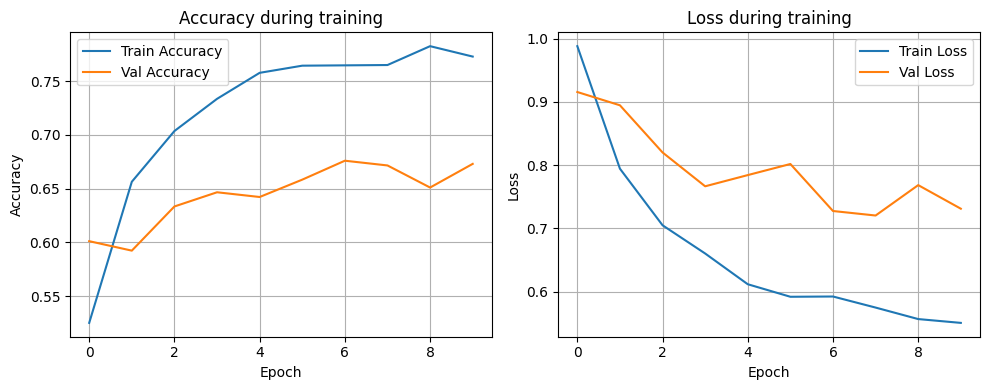

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy') # Use model.history.history to access training history
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss') # Use model.history.history to access training history
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Transfer learning (2 Próba)

In [ ]:
df_train['classes'] = df_train['classes'].astype(str)
train_datagen = ImageDataGenerator( # zwiększyłem aguemntacje żeby zniwelować przeuczenie
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 3309 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

num_classes = len(train_generator.class_indices)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64\, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # softmax dla klasyfikacji wieloklasowej

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1./255)
df_validation['classes'] = df_validation['classes'].astype(str)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_validation,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
df_test['classes'] = df_test['classes'].astype(str)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='links',
    y_col='classes',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 682 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # zastosowałem Early stoping w celu niwelacji przeuczenia
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1671s 16s/step - accuracy: 0.4519 - loss: 1.0765 - val_accuracy: 0.6012 - val_loss: 0.9156
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 64s 615ms/step - accuracy: 0.6395 - loss: 0.8185 - val_accuracy: 0.5924 - val_loss: 0.8946
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 64s 612ms/step - accuracy: 0.6967 - loss: 0.7228 - val_accuracy: 0.6334 - val_loss: 0.8200
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 636ms/step - accuracy: 0.7312 - loss: 0.6640 - val_accuracy: 0.6466 - val_loss: 0.7665
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 64s 612ms/step - accuracy: 0.7631 - loss: 0.6151 - val_accuracy: 0.6422 - val_loss: 0.7842
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 625ms/step - accuracy: 0.7713 - loss: 0.5972 - val_accuracy: 0.6584 - val_loss: 0.8018
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 66s 633ms/step - accuracy: 0.7669 - loss: 0.5937 - val_accuracy: 0.6760 - val_loss: 0.7274
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 80s 618ms/step - accuracy: 0.7554 - loss: 0

In [ ]:
#  # dodałem po nauczeniu modelu kolejną cześć  gdzie trenuje się model z transfer learningu
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False
# model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # uczę jeszcze raz już z dodanymi warstwami
# fine_tune_history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=5
# )

Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.6842 - loss: 0.7518 - val_accuracy: 0.5953 - val_loss: 0.8641
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.7420 - loss: 0.6194 - val_accuracy: 0.5674 - val_loss: 0.9535
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.7838 - loss: 0.5401 - val_accuracy: 0.5630 - val_loss: 1.0090
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.7826 - loss: 0.5309 - val_accuracy: 0.5484 - val_loss: 1.1339
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.8075 - loss: 0.5014 - val_accuracy: 0.5543 - val_loss: 1.1932


In [ ]:
model.save('/content/drive/MyDrive/sensoryczne/model2.keras')


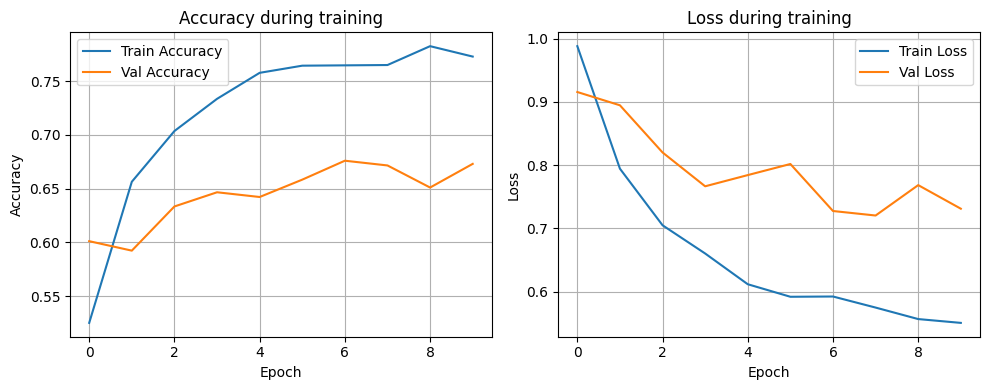

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], label='Train Accuracy') # Use model.history.history to access training history
plt.plot(model.history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'], label='Train Loss') # Use model.history.history to access training history
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#Program Real-Time

In [ ]:
import cv2
import numpy as np
import joblib
import mediapipe as mp
import time

# Wczytaj model RandomForest i scaler
model = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")

CLASS_MAP = {
    0: "looks good",
    1: "sit up straight"
}

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_draw = mp.solutions.drawing_utils

def extract_features(landmarkss):
    landmarks = np.array(landmarkss, dtype=np.float32)

    # Obsługa confidence
    confidence_score = np.mean(landmarks[:, 2]) if landmarks.shape[1] > 2 else 1.0

    # Współrzędne 2D
    landmarks_2d = landmarks[:, :2]

    # Kluczowe punkty
    nose = landmarks_2d[0]
    left_eye = landmarks_2d[2]
    right_eye = landmarks_2d[5]
    left_ear = landmarks_2d[7]
    right_ear = landmarks_2d[8]
    left_shoulder = landmarks_2d[9]
    right_shoulder = landmarks_2d[10]
    left_elbow = landmarks_2d[11]
    right_elbow = landmarks_2d[12]

    mid_shoulder = (left_shoulder + right_shoulder) / 2
    mid_eyes = (left_eye + right_eye) / 2
    horiz = np.array([1.0, 0.0])
    vertical = np.array([0.0, -1.0])

    def angle_between(v1, v2):
        v1 = v1 / (np.linalg.norm(v1) + 1e-8)
        v2 = v2 / (np.linalg.norm(v2) + 1e-8)
        return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

    shoulder_width = np.linalg.norm(right_shoulder - left_shoulder) + 1e-8

    # Cechy kątowe
    angle_feats = [
        angle_between(right_shoulder - left_shoulder, nose - mid_shoulder),
        angle_between(right_shoulder - left_shoulder, horiz),
        angle_between(nose - mid_shoulder, vertical),
        angle_between(left_elbow - left_shoulder, horiz),
        angle_between(right_elbow - right_shoulder, horiz),
        np.linalg.norm(right_shoulder - left_shoulder) / 2.0,
        (left_shoulder[1] - right_shoulder[1]) / shoulder_width,
        (nose[0] - mid_shoulder[0]) / shoulder_width,
    ]

    selected_points = [nose, left_eye, right_eye, left_ear, right_ear,
                       left_shoulder, right_shoulder, left_elbow, right_elbow, mid_shoulder]
    coords = np.concatenate(selected_points) / shoulder_width

    dists = np.array([
        np.linalg.norm(nose - left_shoulder),
        np.linalg.norm(nose - right_shoulder),
        np.linalg.norm(left_eye - left_shoulder),
        np.linalg.norm(right_eye - right_shoulder),
        np.linalg.norm(left_shoulder - left_elbow),
        np.linalg.norm(right_shoulder - right_elbow),
    ]) / shoulder_width

    # Zaawansowane cechy geometryczne
    ear_height_diff = (left_ear[1] - right_ear[1]) / shoulder_width
    symmetry = (np.linalg.norm(left_shoulder - left_elbow) - np.linalg.norm(right_shoulder - right_elbow)) / shoulder_width
    eye_ear_height_diff = (mid_eyes[1] - ((left_ear[1] + right_ear[1]) / 2)) / shoulder_width
    shoulder_elbow_diff_L = (left_shoulder[1] - left_elbow[1]) / shoulder_width
    shoulder_elbow_diff_R = (right_shoulder[1] - right_elbow[1]) / shoulder_width
    head_angle = angle_between(nose - mid_eyes, mid_eyes - mid_shoulder)
    eye_horizontal_diff = (left_eye[0] - right_eye[0]) / shoulder_width
    ear_horizontal_diff = (left_ear[0] - right_ear[0]) / shoulder_width
    neck_height = np.linalg.norm(nose - mid_shoulder) / shoulder_width
    shoulder_to_neck_ratio = shoulder_width / (neck_height + 1e-8)
    head_centering = abs(nose[0] - mid_shoulder[0]) / shoulder_width

    extra_features = np.array([
        symmetry,
        ear_height_diff,
        eye_ear_height_diff,
        shoulder_elbow_diff_L,
        shoulder_elbow_diff_R,
        head_angle,
        eye_horizontal_diff,
        ear_horizontal_diff,
        shoulder_to_neck_ratio,
        head_centering,
        confidence_score
    ])

    feature_vector = np.concatenate([angle_feats, coords, dists, extra_features])
    return feature_vector.reshape(1, -1)


# Kamera
cap = cv2.VideoCapture(0)
previous_landmarks = None
frames = 0
start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    label = "No person detected"
    confidence = 0.0

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        previous_landmarks = landmarks
    elif previous_landmarks is not None:
        landmarks = previous_landmarks
    else:
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow('Posture Detection', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    try:
        data = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])
        required_indices = [0, 2, 5, 7, 8, 9, 10]
        if any(results.pose_landmarks.landmark[i].visibility < 0.5 for i in required_indices):
            raise ValueError("Missing or occluded key landmarks")

        features = extract_features(data)
        if np.any(np.isnan(features)) or np.any(np.isinf(features)) or features.shape[1] != 45:
            raise ValueError("Invalid features")

        scaled = scaler.transform(features)
        probs = model.predict_proba(scaled)[0]
        pred = np.argmax(probs)
        conf = probs[pred]
        # print("Features (scaled):", scaled)
        # print("Probs:", probs)
        if conf > 0.5:
            label = CLASS_MAP[pred]
            confidence = conf
        else:
            label = "Uncertain"

        mp_draw.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    except Exception as e:
        label = "Invalid frame"
        confidence = 0.0
        print(f"[Warning] {e}")

    # FPS
    frames += 1
    if time.time() - start_time >= 1.0:
        print(f"[Info] FPS: {frames}")
        frames = 0
        start_time = time.time()

    # Wynik
    color = (0, 255, 0) if confidence > 0.8 else (0, 0, 255)
    cv2.putText(frame, f"Posture: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.imshow('Posture Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Wciśnij 'q', aby zakończyć


#Finalna Wersja

##CNN

In [30]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from pathlib import Path



0: x=0.54, y=0.62
1: x=-2.39, y=1.00
2: x=0.59, y=0.52
3: x=-2.35, y=1.00
4: x=0.61, y=0.52
5: x=-2.35, y=1.00
6: x=0.63, y=0.53
7: x=-2.35, y=1.00
8: x=0.50, y=0.52
9: x=-2.37, y=1.00
10: x=0.47, y=0.52
11: x=-2.37, y=1.00
12: x=0.44, y=0.52
13: x=-2.37, y=1.00
14: x=0.67, y=0.56
15: x=-1.82, y=1.00
16: x=0.41, y=0.55
17: x=-1.85, y=1.00
18: x=0.58, y=0.72
19: x=-2.17, y=1.00
20: x=0.49, y=0.72
21: x=-2.18, y=1.00
22: x=0.81, y=0.92
23: x=-1.27, y=1.00
24: x=0.21, y=0.87
25: x=-1.37, y=1.00
26: x=1.01, y=1.36
27: x=-1.12, y=0.42
28: x=0.07, y=1.45
29: x=-1.32, y=0.56
30: x=1.03, y=1.78
31: x=-1.48, y=0.10
32: x=0.05, y=1.87
33: x=-1.97, y=0.15
34: x=1.07, y=1.92
35: x=-1.59, y=0.06
36: x=0.02, y=2.02
37: x=-2.11, y=0.11
38: x=1.02, y=1.93
39: x=-1.65, y=0.09
40: x=0.06, y=2.00
41: x=-2.22, y=0.16
42: x=0.99, y=1.89
43: x=-1.52, y=0.11
44: x=0.09, y=1.95
45: x=-2.02, y=0.15
46: x=0.66, y=1.81
47: x=-0.10, y=0.00
48: x=0.30, y=1.79
49: x=0.10, y=0.00
50: x=0.63, y=2.59
51: x=0.21, y=0.0

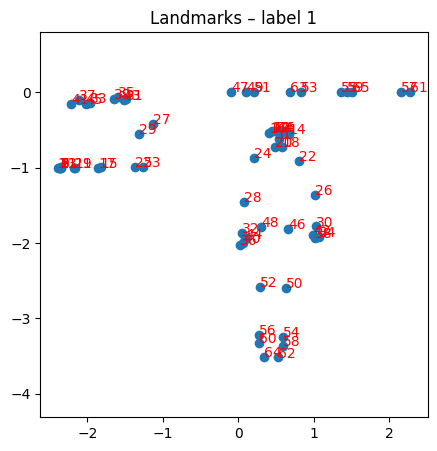

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Załaduj jeden plik .npz
data = np.load('/content/drive/MyDrive/sensoryczne/landmarks/train/extract0001_jpg.rf.0a6b511f137696c1944c2b047fc72d4b.npz')

landmarks = data['landmarks']  # shape: (2*N,) lub (N, 2)
label = data['label']

# Jeśli shape to (2*N,), to przekształcamy
if landmarks.ndim == 1:
    landmarks = landmarks.reshape(-1, 2)

# Wyświetl indeksy i współrzędne
for idx, (x, y) in enumerate(landmarks):
    print(f"{idx}: x={x:.2f}, y={y:.2f}")
plt.figure(figsize=(5, 5))
plt.scatter(landmarks[:, 0], -landmarks[:, 1])  # odwrócenie Y, żeby wyglądało jak na obrazie
for i, (x, y) in enumerate(landmarks):
    plt.text(x, -y, str(i), fontsize=10, color='red')
plt.title(f"Landmarks – label {label}")
plt.axis('equal')
plt.show()

In [45]:

def angle_between(v1, v2):
    """Zwraca kąt w radianach między dwoma wektorami 2D."""
    v1 = v1 / (torch.norm(v1) + 1e-8)
    v2 = v2 / (torch.norm(v2) + 1e-8)
    dot_product = torch.dot(v1, v2)
    angle = torch.acos(torch.clamp(dot_product, -1.0, 1.0))
    return angle
def triangle_area(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * torch.abs(ab[0]*ac[1] - ab[1]*ac[0])

In [54]:
from collections import defaultdict
import random
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from pathlib import Path

def angle_between(v1, v2):
    """Zwraca kąt w radianach między dwoma wektorami 2D."""
    v1 = v1 / (torch.norm(v1) + 1e-8)
    v2 = v2 / (torch.norm(v2) + 1e-8)
    dot_product = torch.dot(v1, v2)
    angle = torch.acos(torch.clamp(dot_product, -1.0, 1.0))
    return angle
def triangle_area(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * torch.abs(ab[0]*ac[1] - ab[1]*ac[0])

class PoseAngleFeatureDataset(Dataset):
    def __init__(self, landmark_dir, max_samples_per_class=200, augment_prob=0.15, noise_std=0.01):
        self.files_by_class = defaultdict(list)
        self.augment_prob = augment_prob
        self.noise_std = noise_std
        all_files = list(Path(landmark_dir).rglob('*.npz'))


        for file in all_files:
            try:
                data = np.load(file)
                label = int(data['label'])
                # Połącz klasy 1 i 2 w nową klasę 1
                if label == 2:
                    label = 1

                self.files_by_class[label].append(file)
            except Exception as e:
                # Handle corrupted or unreadable .npz files by skipping them
                # print(f"Error loading file {file}: {e}") # Optional: uncomment for debugging
                continue

        self.balanced_files = []
        # Find the minimum class length among existing classes
        existing_classes = [label for label, files in self.files_by_class.items() if files]
        if not existing_classes:
            # No valid files found
            return

        min_class_len = min(len(self.files_by_class[label]) for label in existing_classes)

        # Populate balanced_files by sampling from existing classes
        for label in existing_classes:
            files = self.files_by_class[label]
            selected = random.sample(files, min_class_len)
            self.balanced_files.extend(selected)

        random.shuffle(self.balanced_files)

    def __len__(self):
        return len(self.balanced_files)

    def __getitem__(self, idx):
        data = np.load(self.balanced_files[idx])
        landmarks = data["landmarks"].astype(np.float32)
        label = int(data["label"])
        if label == 2:
            label = 1
        landmarks = torch.tensor(landmarks).view(-1, 2)
        # --- Wyodrębnienie punktów ---
        nose = landmarks[0]
        left_eye = landmarks[2]
        right_eye = landmarks[5]
        left_ear = landmarks[7]
        right_ear = landmarks[8]
        left_shoulder = landmarks[9]
        right_shoulder = landmarks[10]
        left_elbow = landmarks[11]
        right_elbow = landmarks[12]

        mid_shoulder = (left_shoulder + right_shoulder) / 2
        mid_eyes = (left_eye + right_eye) / 2
        horiz = torch.tensor([1.0, 0.0])
        vertical = torch.tensor([0.0, -1.0])

        # --- Kątowe cechy (11) ---
        angle_feats = [
            angle_between(right_shoulder - left_shoulder, nose - mid_shoulder),
            angle_between(right_eye - left_eye, nose - mid_eyes),
            angle_between(right_shoulder - left_shoulder, horiz),
            angle_between(nose - mid_shoulder, vertical),
            torch.norm(right_shoulder - left_shoulder) / 2.0,
            left_shoulder[1] - right_shoulder[1],
            nose[0] - mid_shoulder[0],
            angle_between(right_eye - left_eye, horiz),
            torch.norm(right_eye - left_eye),
            torch.norm(nose - mid_eyes),
            angle_between(left_ear - nose, right_ear - nose)
        ]
        angle_feats = torch.stack([torch.tensor(f) if not isinstance(f, torch.Tensor) else f for f in angle_feats])

        # --- Współrzędne 10 punktów (20 cech) ---
        selected_points = [nose, left_eye, right_eye, left_ear, right_ear,
                           left_shoulder, right_shoulder, left_elbow, right_elbow, mid_shoulder]
        coords = torch.cat(selected_points).view(-1)

        # --- Odległości metryczne (6 cech) ---
        extra_dists = torch.tensor([
            torch.norm(nose - left_shoulder),
            torch.norm(nose - right_shoulder),
            torch.norm(left_eye - left_shoulder),
            torch.norm(right_eye - right_shoulder),
            torch.norm(left_shoulder - left_elbow),
            torch.norm(right_shoulder - right_elbow),
        ])

        # --- Pole trójkąta (1 cecha) ---
        triangle_feat = triangle_area(nose, left_shoulder, right_shoulder)

        # --- Symetria długości ramion (1 cecha) ---
        shoulder_len_diff = torch.norm(left_shoulder - left_elbow) - torch.norm(right_shoulder - right_elbow)

        extras = torch.tensor([triangle_feat, shoulder_len_diff])

        # --- Łączymy wszystko ---
        full_vector = torch.cat([angle_feats, coords, extra_dists, extras])  # (39,)

        return full_vector, torch.tensor(label)

In [ ]:
# from collections import defaultdict
# import random

# class PoseAngleFeatureDataset(Dataset):
#     def __init__(self, landmark_dir, max_samples_per_class=200, augment_prob=0.25, noise_std=0.025):
#         self.files_by_class = defaultdict(list)
#         self.augment_prob = augment_prob
#         self.noise_std = noise_std

#         all_files = list(Path(landmark_dir).rglob("*.npz"))
#         for file in all_files:
#             label = int(np.load(file)['label'])
#             self.files_by_class[label].append(file)

#         # Balansowanie: wyrównaj liczby przykładów we wszystkich klasach
#         self.balanced_files = []
#         for label, files in self.files_by_class.items():
#             selected = random.choices(files, k=max_samples_per_class) if len(files) < max_samples_per_class else random.sample(files, max_samples_per_class)
#             self.balanced_files.extend(selected)

#         random.shuffle(self.balanced_files)

#     def __len__(self):
#         return len(self.balanced_files)
#     def __getitem__(self, idx):
#         data = np.load(self.balanced_files[idx])
#         landmarks = data["landmarks"].astype(np.float32)
#         label = int(data["label"])
#         landmarks = torch.tensor(landmarks).view(-1, 2)
#         if torch.rand(1).item() < self.augment_prob:
#             noise = torch.randn_like(landmarks) * self.noise_std
#             landmarks = landmarks + noise
#         # Wyodrębnij punkty
#         nose = landmarks[0]
#         left_eye = landmarks[2]
#         right_eye = landmarks[5]
#         left_ear = landmarks[7]
#         right_ear = landmarks[8]
#         left_shoulder = landmarks[9]
#         right_shoulder = landmarks[10]
#         left_elbow = landmarks[11]
#         right_elbow = landmarks[12]

#         mid_shoulder = (left_shoulder + right_shoulder) / 2
#         mid_eyes = (left_eye + right_eye) / 2
#         horiz = torch.tensor([1.0, 0.0])
#         vertical = torch.tensor([0.0, -1.0])

#         # 11 cech kątowych
#         features = [
#             angle_between(right_shoulder - left_shoulder, nose - mid_shoulder),
#             angle_between(right_eye - left_eye, nose - mid_eyes),
#             angle_between(right_shoulder - left_shoulder, horiz),
#             angle_between(nose - mid_shoulder, vertical),
#             torch.norm(right_shoulder - left_shoulder) / 2.0,
#             left_shoulder[1] - right_shoulder[1],
#             nose[0] - mid_shoulder[0],
#             angle_between(right_eye - left_eye, horiz),
#             torch.norm(right_eye - left_eye),
#             torch.norm(nose - mid_eyes),
#             angle_between(left_ear - nose, right_ear - nose)
#         ]
#         angle_feats = torch.stack(features)  # (11,)

#         # Dodajemy 20 współrzędnych (10 punktów × 2)
#         selected_points = [
#             nose, left_eye, right_eye, left_ear, right_ear,
#             left_shoulder, right_shoulder, left_elbow, right_elbow, mid_shoulder
#         ]
#         coords = torch.cat([p for p in selected_points]).view(-1)  # (20,)

#         final_features = torch.cat([angle_feats, coords])  # (31,)
#         return final_features, torch.tensor(label)

#     # def __getitem__(self, idx):
    #     data = np.load(self.balanced_files[idx])
    #     landmarks = data["landmarks"].astype(np.float32)
    #     label = int(data["label"])
    #     landmarks = torch.tensor(landmarks).view(-1, 2)

    #     # if torch.rand(1).item() < self.augment_prob:
    #     #     noise = torch.randn_like(landmarks) * self.noise_std
    #     #     landmarks = landmarks + noise

    #     # --- Feature extraction (tak jak wcześniej) ---
    #     # Wyodrębnij punkty
    #     nose = landmarks[0]
    #     left_eye = landmarks[2]
    #     right_eye = landmarks[5]
    #     left_ear = landmarks[7]
    #     right_ear = landmarks[8]
    #     left_shoulder = landmarks[9]
    #     right_shoulder = landmarks[10]

    #     mid_shoulder = (left_shoulder + right_shoulder) / 2
    #     mid_eyes = (left_eye + right_eye) / 2
    #     horiz = torch.tensor([1.0, 0.0])
    #     vertical = torch.tensor([0.0, -1.0])

    #     features = [
    #         torch.tensor(angle_between(right_shoulder - left_shoulder, nose - mid_shoulder)),
    #         torch.tensor(angle_between(right_eye - left_eye, nose - mid_eyes)),
    #         torch.tensor(angle_between(right_shoulder - left_shoulder, horiz)),
    #         torch.tensor(angle_between(nose - mid_shoulder, vertical)),
    #         torch.norm(right_shoulder - left_shoulder) / 2.0,
    #         left_shoulder[1] - right_shoulder[1],
    #         nose[0] - mid_shoulder[0],
    #         torch.tensor(angle_between(right_eye - left_eye, horiz)),
    #         torch.norm(right_eye - left_eye),
    #         torch.norm(nose - mid_eyes),
    #         torch.tensor(angle_between(left_ear - nose, right_ear - nose))
    #     ]

    #     feature_vector = torch.stack(features)  # shape: (11,)
    #     return feature_vector, torch.tensor(label)


In [49]:
from collections import defaultdict
import random
import os

train_ds = PoseAngleFeatureDataset('/content/drive/MyDrive/sensoryczne/landmarks/train')
val_ds   = PoseAngleFeatureDataset('/content/drive/MyDrive/sensoryczne/landmarks/valid')

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


EOFError: No data left in file

In [56]:
# Zbierz dane treningowe
X_train = []
y_train = []

for x, y in train_ds:
    X_train.append(x.numpy())
    y_train.append(y.item())

X_train = np.array(X_train)
y_train = np.array(y_train)


In [38]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, '/content/drive/MyDrive/sensoryczne/scaler.pkl')

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
X_val = []
y_val = []

for x, y in val_ds:
    X_val.append(x.numpy())
    y_val.append(y.item())

X_val = np.array(X_val)
y_val = np.array(y_val)

X_val_scaled = scaler.transform(X_val)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_tensor_ds = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                 torch.tensor(y_train, dtype=torch.long))
val_tensor_ds = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                              torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_tensor_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensor_ds, batch_size=32)

In [ ]:
# torch.save(train_tensor_ds, "/content/drive/MyDrive/sensoryczne/train_tensor_dataset.pt")
# torch.save(val_tensor_ds, "/content/drive/MyDrive/sensoryczne/val_tensor_dataset.pt")

In [ ]:
# train_loaded_dataset = torch.load("/content/drive/MyDrive/sensoryczne/train_tensor_dataset.pt",weights_only=False)
# val_loaded_dataset = torch.load("/content/drive/MyDrive/sensoryczne/val_tensor_dataset.pt",weights_only=False)


In [ ]:
train_loader = DataLoader(train_loaded_dataset , batch_size=32, shuffle=True)
val_loader = DataLoader(val_loaded_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PoseClassifier(nn.Module):
    def __init__(self, input_dim=39, num_classes=2):
        super(PoseClassifier, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class_counts = np.bincount(y_train)
print(class_counts)
class_weights = 1. / class_counts
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

[1674 1674]


In [ ]:
model = PoseClassifier(input_dim=39, num_classes=2)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

PoseClassifier(
  (net): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)


Epoch 1 | Train loss: 0.5626
Epoch 2 | Train loss: 0.4578
Epoch 3 | Train loss: 0.4242
Epoch 4 | Train loss: 0.4039
Epoch 5 | Train loss: 0.3944
Epoch 6 | Train loss: 0.3811
Epoch 7 | Train loss: 0.3849
Epoch 8 | Train loss: 0.3649
Epoch 9 | Train loss: 0.3675
Epoch 10 | Train loss: 0.3571
Epoch 11 | Train loss: 0.3540
Epoch 12 | Train loss: 0.3587
Epoch 13 | Train loss: 0.3490
Epoch 14 | Train loss: 0.3567
Epoch 15 | Train loss: 0.3401


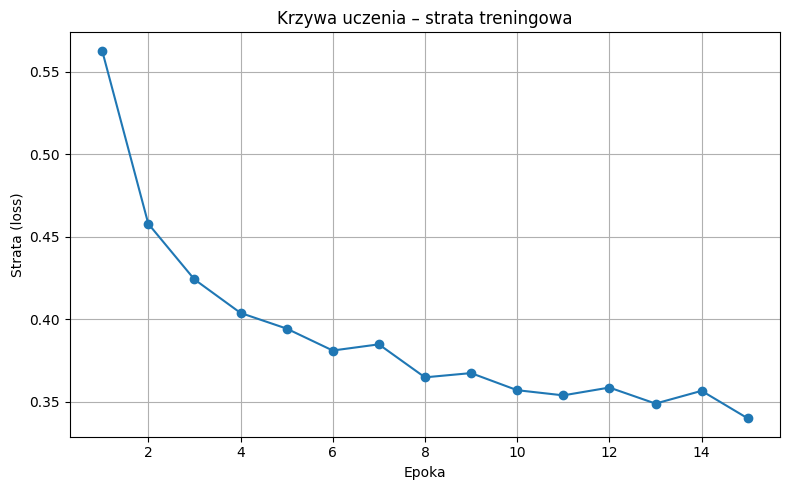

In [ ]:
train_losses = []

# Pętla treningowa
for epoch in range(15):
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Train loss: {avg_loss:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Krzywa uczenia – strata treningowa")
plt.xlabel("Epoka")
plt.ylabel("Strata (loss)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
val_loss = 0
val_correct = 0

with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
        val_logits = model(X_val_batch)
        val_loss += criterion(val_logits, y_val_batch).item()
        val_preds = val_logits.argmax(dim=1)
        val_correct += (val_preds == y_val_batch).sum().item()

val_loss /= len(val_loader)
val_acc = val_correct / len(val_loader.dataset)
print(f"Epoch {epoch+1} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.2%}")

Epoch 15 | Val loss: 0.3403 | Val acc: 84.97%


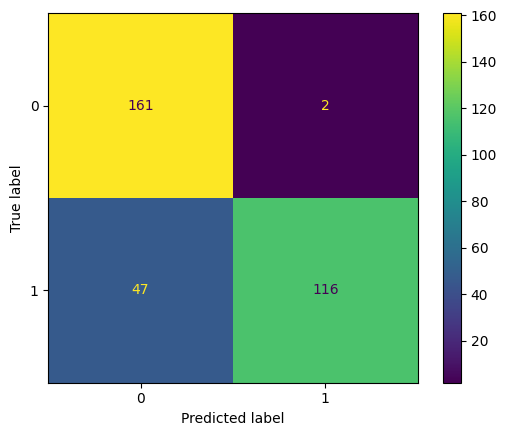

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/sensoryczne/model_state_dict.pt")

##Random forest (MAIN)

In [57]:
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import torch
from torch.utils.data import Dataset

In [58]:
def augment_landmarks(landmarks, noise_std=0.003, shift_range=5, scale_range=0.05):
    lm = np.array(landmarks, dtype=np.float32)

    noise = np.random.normal(0, noise_std, lm[:, :2].shape)
    lm[:, :2] += noise


    shift = np.random.uniform(-shift_range, shift_range, size=(1, 2))
    lm[:, :2] += shift


    center = (lm[9, :2] + lm[10, :2]) / 2
    scale_factor = 1 + np.random.uniform(-scale_range, scale_range)
    lm[:, :2] = center + (lm[:, :2] - center) * scale_factor

    return lm


In [62]:
class PoseAngleFeatureDataset1:
    def __init__(self, landmark_dir, max_samples_per_class=200, noise_std=0.005, bias_factor=2):
        self.noise_std = noise_std
        self.files_by_class = defaultdict(list)
        all_files = list(Path(landmark_dir).rglob("*.npz"))

        for file in all_files:
            try:
                data = np.load(file)
                label = int(data['label'])
                if label not in [0, 1, 2]:
                    continue
                if label == 0:
                    self.files_by_class[0].append(file)
                else:
                    self.files_by_class[1].append(file)  # scal klasy 1 i 2 do klasy 1
            except Exception as e:
                # Handle corrupted or unreadable .npz files by skipping them
                # print(f"Error loading file {file}: {e}") # Optional: uncomment for debugging
                continue


        min_len = min(len(self.files_by_class[0]) // bias_factor, len(self.files_by_class[1]))
        self.balanced_files = []

        # Bias – klasa 0 dostaje więcej przykładów (np. 2x więcej niż klasa 1)
        n0 = min(min_len * bias_factor, len(self.files_by_class[0]))
        n1 = min(min_len, len(self.files_by_class[1]))

        self.balanced_files.extend(random.sample(self.files_by_class[0], n0))
        self.balanced_files.extend(random.sample(self.files_by_class[1], n1))

        random.shuffle(self.balanced_files)

    def __len__(self):
        return len(self.balanced_files)

    def __getitem__(self, idx):
        while True:
            data = np.load(self.balanced_files[idx])
            label = int(data["label"])
            if label == 0:
                label = 0
            elif label in [1, 2]:
                label = 1
            else:
                idx = random.randint(0, len(self.balanced_files) - 1)
                continue
            break

        landmarks = data["landmarks"].astype(np.float32)
        landmarks = torch.tensor(landmarks).view(-1, 3)

        landmarks[:, :2] += torch.randn_like(landmarks[:, :2]) * self.noise_std
        confidence_score = landmarks[:, 2].mean().item()
        landmarks_2d = landmarks[:, :2]

        nose = landmarks_2d[0]
        left_eye = landmarks_2d[2]
        right_eye = landmarks_2d[5]
        left_ear = landmarks_2d[7]
        right_ear = landmarks_2d[8]
        left_shoulder = landmarks_2d[9]
        right_shoulder = landmarks_2d[10]
        left_elbow = landmarks_2d[11]
        right_elbow = landmarks_2d[12]

        mid_shoulder = (left_shoulder + right_shoulder) / 2
        mid_eyes = (left_eye + right_eye) / 2
        horiz = torch.tensor([1.0, 0.0])
        vertical = torch.tensor([0.0, -1.0])

        def angle_between(v1, v2):
            v1 = v1 / (torch.norm(v1) + 1e-8)
            v2 = v2 / (torch.norm(v2) + 1e-8)
            return torch.acos(torch.clamp(torch.dot(v1, v2), -1.0, 1.0))

        shoulder_width = torch.norm(right_shoulder - left_shoulder) + 1e-8

        angle_feats = [
            angle_between(right_shoulder - left_shoulder, nose - mid_shoulder),
            angle_between(right_shoulder - left_shoulder, horiz),
            angle_between(nose - mid_shoulder, vertical),
            angle_between(left_elbow - left_shoulder, horiz),
            angle_between(right_elbow - right_shoulder, horiz),
            torch.norm(right_shoulder - left_shoulder) / 2.0,
            (left_shoulder[1] - right_shoulder[1]) / shoulder_width,
            (nose[0] - mid_shoulder[0]) / shoulder_width,
        ]

        coords = torch.cat([
            nose, left_eye, right_eye, left_ear, right_ear,
            left_shoulder, right_shoulder, left_elbow, right_elbow, mid_shoulder
        ]) / shoulder_width

        dists = torch.tensor([
            torch.norm(nose - left_shoulder),
            torch.norm(nose - right_shoulder),
            torch.norm(left_eye - left_shoulder),
            torch.norm(right_eye - right_shoulder),
            torch.norm(left_shoulder - left_elbow),
            torch.norm(right_shoulder - right_elbow),
        ]) / shoulder_width

        ear_height_diff = (left_ear[1] - right_ear[1]) / shoulder_width
        symmetry = (torch.norm(left_shoulder - left_elbow) - torch.norm(right_shoulder - right_elbow)) / shoulder_width
        eye_ear_height_diff = (mid_eyes[1] - ((left_ear[1] + right_ear[1]) / 2)) / shoulder_width
        shoulder_elbow_diff_L = (left_shoulder[1] - left_elbow[1]) / shoulder_width
        shoulder_elbow_diff_R = (right_shoulder[1] - right_elbow[1]) / shoulder_width
        head_angle = angle_between(nose - mid_eyes, mid_eyes - mid_shoulder)
        eye_horizontal_diff = (left_eye[0] - right_eye[0]) / shoulder_width
        ear_horizontal_diff = (left_ear[0] - right_ear[0]) / shoulder_width
        neck_height = torch.norm(nose - mid_shoulder) / shoulder_width
        shoulder_to_neck_ratio = shoulder_width / (neck_height + 1e-8)
        head_centering = abs(nose[0] - mid_shoulder[0]) / shoulder_width

        extra_features = torch.tensor([
            symmetry,
            ear_height_diff,
            eye_ear_height_diff,
            shoulder_elbow_diff_L,
            shoulder_elbow_diff_R,
            head_angle,
            eye_horizontal_diff,
            ear_horizontal_diff,
            shoulder_to_neck_ratio,
            head_centering,
            confidence_score
        ])

        all_feats = [t.unsqueeze(0) if t.ndim == 0 else t for t in angle_feats + [coords, dists, extra_features]]
        feature_vector = torch.cat(all_feats).numpy()
        return feature_vector, label

In [63]:
from collections import defaultdict
import random


def load_balanced_dataset(dataset, max_per_class=None, oversample=False):
    class_samples = defaultdict(list)

    # Zgrupuj po klasach
    for i in range(len(dataset)):
        x, y = dataset[i]
        class_samples[y].append(x)

    if max_per_class is None:
        min_len = min(len(v) for v in class_samples.values())
    else:
        min_len = max_per_class

    X_balanced, y_balanced = [], []

    for cls, samples in class_samples.items():
        if oversample:
            selected = random.choices(samples, k=min_len)  # powtarzanie mniejszych klas
        else:
            selected = samples[:min(min_len, len(samples))]  # ucinanie większych

        X_balanced.extend(selected)
        y_balanced.extend([cls] * len(selected))

    return np.array(X_balanced), np.array(y_balanced)

In [64]:
train_ds = PoseAngleFeatureDataset1("/content/drive/MyDrive/sensoryczne/landmarks/train")
val_ds   = PoseAngleFeatureDataset1("/content/drive/MyDrive/sensoryczne/landmarks/valid")
X_train, y_train = zip(*[train_ds[i] for i in range(len(train_ds))])

X_val, y_val     = zip(*[val_ds[i] for i in range(len(val_ds))])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [65]:
np.save("/content/drive/MyDrive/sensoryczne/ref_vecto.npy",train_ds.reference_vector)

AttributeError: 'PoseAngleFeatureDataset1' object has no attribute 'reference_vector'

In [66]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, '/content/drive/MyDrive/sensoryczne/scaler.pkl')

['/content/drive/MyDrive/sensoryczne/scaler.pkl']

In [67]:
X_val_scaled = scaler.transform(X_val)

In [68]:
from collections import Counter
print(Counter(y_train))

Counter({np.int64(0): 836, np.int64(1): 418})


In [69]:
clf = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=42)

In [70]:
y_pred = clf.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)

In [71]:
report = classification_report(y_val, y_pred)

In [72]:
conf_matrix = confusion_matrix(y_val, y_pred)

In [73]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8847736625514403
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       162
           1       0.86      0.78      0.82        81

    accuracy                           0.88       243
   macro avg       0.88      0.86      0.87       243
weighted avg       0.88      0.88      0.88       243

Confusion Matrix:
 [[152  10]
 [ 18  63]]


In [74]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [f"feat_{i}" for i in range(X_train.shape[1])]

feat_16: 0.0661
feat_13: 0.0508
feat_32: 0.0496
feat_8: 0.0485
feat_1: 0.0485
feat_6: 0.0439
feat_24: 0.0354
feat_43: 0.0352
feat_34: 0.0335
feat_44: 0.0311
feat_19: 0.0310
feat_42: 0.0290
feat_37: 0.0290
feat_4: 0.0276
feat_36: 0.0259
feat_7: 0.0230
feat_39: 0.0222
feat_41: 0.0206
feat_0: 0.0202
feat_2: 0.0200
feat_38: 0.0195
feat_29: 0.0184
feat_40: 0.0181
feat_33: 0.0178
feat_31: 0.0162
feat_25: 0.0144
feat_17: 0.0143
feat_30: 0.0142
feat_35: 0.0138
feat_9: 0.0133
feat_3: 0.0131
feat_28: 0.0130
feat_14: 0.0128
feat_10: 0.0120
feat_22: 0.0110
feat_23: 0.0109
feat_11: 0.0107
feat_27: 0.0106
feat_12: 0.0094
feat_20: 0.0090
feat_15: 0.0087
feat_5: 0.0085
feat_21: 0.0070
feat_26: 0.0066
feat_18: 0.0057


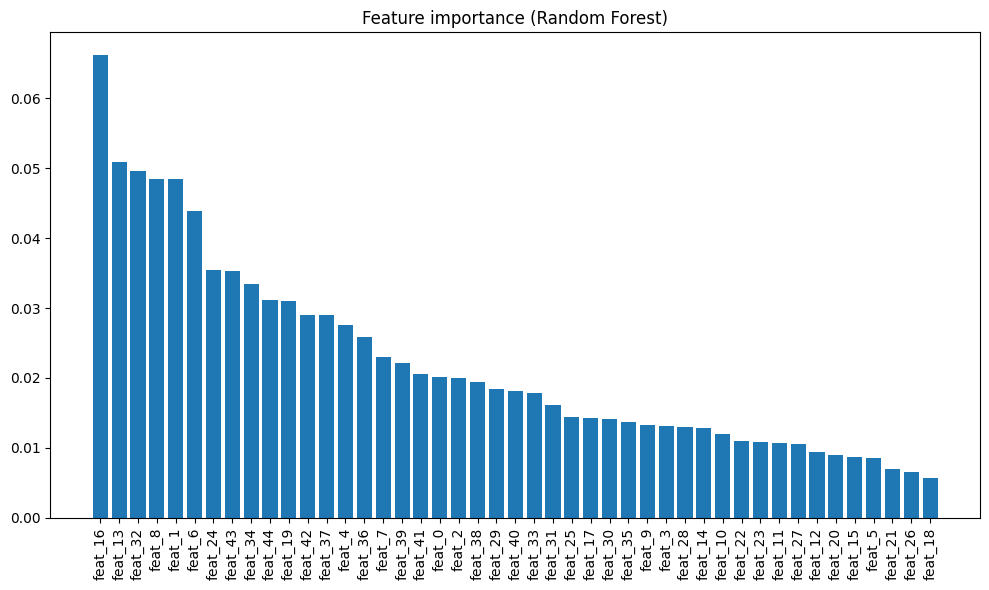

In [75]:
for i in range(len(importances)):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# 📊 Wykres
plt.figure(figsize=(10, 6))
plt.title("Feature importance (Random Forest)")
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [76]:
import joblib
joblib.dump(clf, '/content/drive/MyDrive/sensoryczne/rf_model.pkl')

['/content/drive/MyDrive/sensoryczne/rf_model.pkl']

In [77]:
import pickle

with open("/content/drive/MyDrive/sensoryczne/rf_model.pkl", "wb") as f:
    pickle.dump(clf, f)

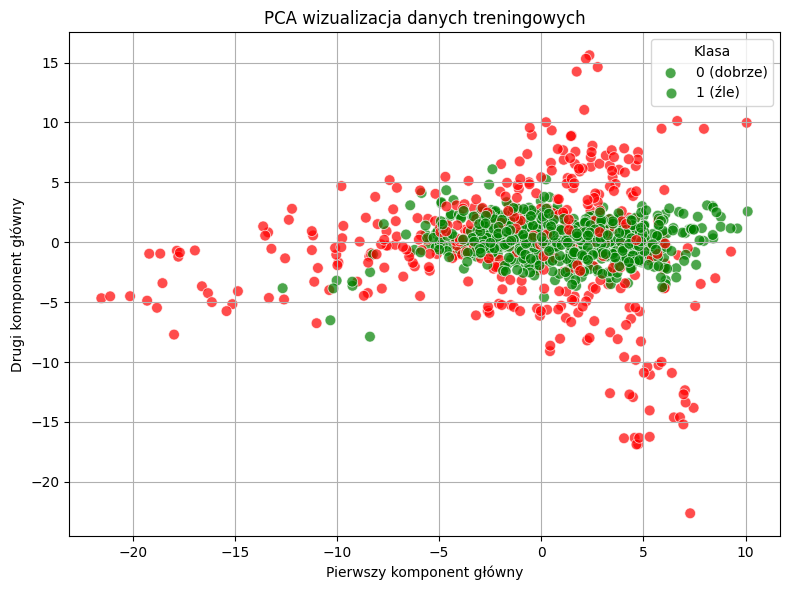

In [80]:
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette=['green', 'red'], s=60, alpha=0.7)
plt.title('PCA wizualizacja danych treningowych')
plt.xlabel('Pierwszy komponent główny')
plt.ylabel('Drugi komponent główny')
plt.legend(title='Klasa', labels=['0 (dobrze)', '1 (źle)'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_train_test_pca(X_train, X_test, y_train, y_test):
    pca = PCA(n_components=2)
    X_all = np.vstack([X_train, X_test])
    X_pca = pca.fit_transform(X_all)

    n_train = len(X_train)
    X_train_pca = X_pca[:n_train]
    X_test_pca = X_pca[n_train:]

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="coolwarm", alpha=0.4, label="Train")
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, marker="x", cmap="coolwarm", s=70, label="Test")
    plt.legend()
    plt.title("PCA: Train vs Test distribution")
    plt.grid(True)
    plt.show()

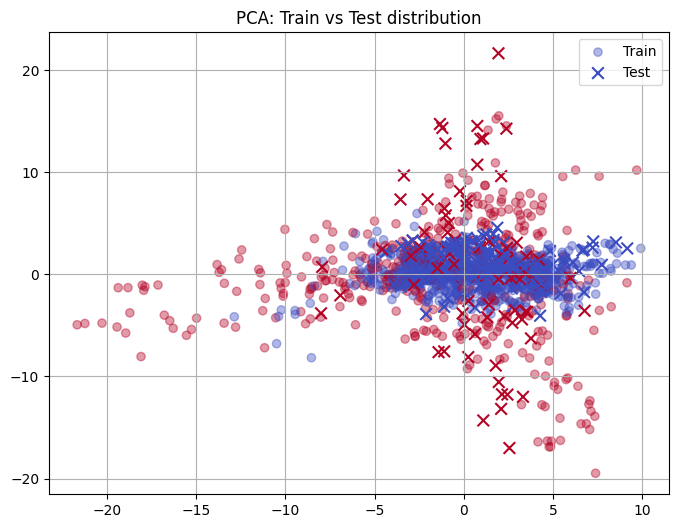

In [82]:
plot_train_test_pca(X_train_scaled, X_val_scaled, y_train, y_val)

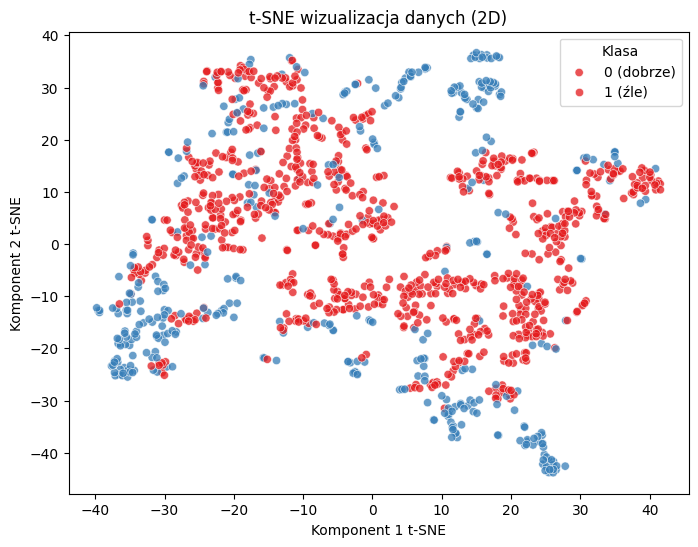

In [83]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='Set1', alpha=0.75, legend='full')
plt.title("t-SNE wizualizacja danych (2D)")
plt.xlabel("Komponent 1 t-SNE")
plt.ylabel("Komponent 2 t-SNE")
plt.legend(title='Klasa', labels=['0 (dobrze)', '1 (źle)']) # Dodanie legendy z opisami klas
plt.show()

In [35]:
from sklearn.preprocessing import StandardScaler
import joblib
scaler = StandardScaler()
X_train = []
y_train = []

for x, y in train_ds:
    X_train.append(x.numpy())
    y_train.append(y.item())

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, '/content/drive/MyDrive/sensoryczne/scaler.pkl')

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

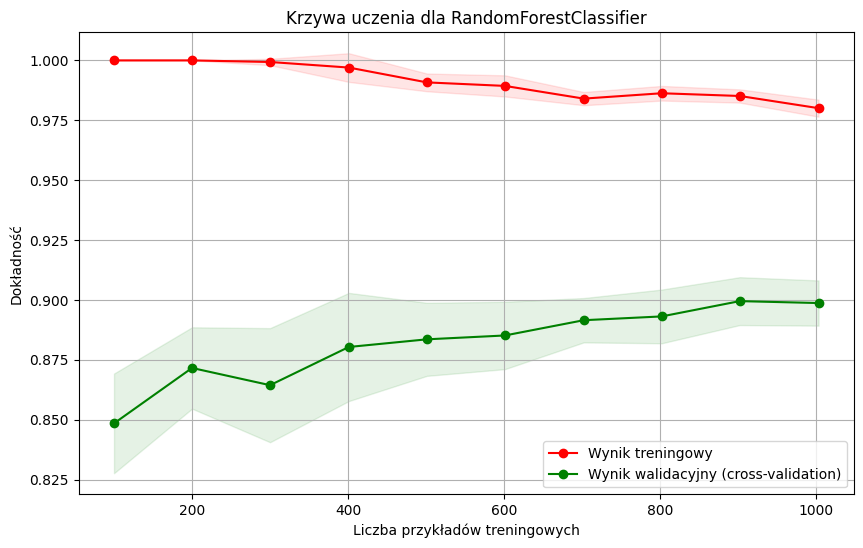

In [85]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Definiujemy rozmiary podzbiorów danych treningowych do użycia
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Obliczamy średnią i odchylenie standardowe dla wyników treningowych i testowych
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Rysujemy krzywą uczenia
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Wynik treningowy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Wynik walidacyjny (cross-validation)")

plt.title("Krzywa uczenia dla RandomForestClassifier")
plt.xlabel("Liczba przykładów treningowych")
plt.ylabel("Dokładność")
plt.legend(loc="best")
plt.grid()
plt.show()